<a href="https://colab.research.google.com/github/davidfox87/neuro_encoding_models/blob/master/fitting_spike_train_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis and prediction of neural activity using a machine learning approach
__Content creator:__ David Fox

In [1]:
#@title Clone the github repository 
!git clone https://github.com/davidfox87/neuro_encoding_models &> /dev/null
%cd neuro_encoding_models/

/content/neuro_encoding_models


In [2]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [3]:
#@title import modules
import numpy as np
from matplotlib import pyplot as plt
from glmtools.make_xdsgn import Experiment, DesignSpec
from scipy.optimize import minimize
from glmtools.model import GLM
from basisFactory.bases import RaisedCosine
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from glmtools.fit import neg_log_lik, mapfit_GLM
from utils.read import load_spk_times2
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
#@title helper functions
def make_bases(dur, peaks, stim_nbases, stretch, dt=0.02):
	fs = 1. / dt
	first_peak, last_peak = peaks
	
	nkt = int(dur * fs) # length of filter in number of samples
	# stim_nbases = number of vectors that are raised cosines
	stim_basis = RaisedCosine(100, stim_nbases, 1, 'stim')
 
	# arguments for makeNonlinearRaisedCosStim are 
	# dt sample interval
	# peaks = [position of first center, position of last center], 
	# stretch = spacing of basis centers (higher value = more linear meaning spread out,
	# lower value = nonlinear more centers near 0)
	# nkt = length of filter. If length of filters exceeds nkt we trim the filters, 
	# otherwise we pad with 0's
	# stim_basis.makeNonlinearRaisedCosStim(.1, [10, round(nkt/1.7)], stretch, nkt)  # first and last peak positions,
	stim_basis.makeNonlinearRaisedCosStim(.1, [first_peak / dt, last_peak / dt], stretch, nkt)
	spike_basis = RaisedCosine(100, 7, 1, 'sphist')
	spike_basis.makeNonlinearRaisedCosPostSpike(0.1, [.1, 10], .1, 0.01)

	return stim_basis, spike_basis

def make_dspec(stim, response, dt):
	# make an Experiment object
	expt = Experiment(dt, len(stim)*dt, stim=stim, response=response)

	# register continuous regressor
	expt.registerContinuous('stim')
	# register spike regressor

	expt.register_spike_train('sptrain')
	# initialize design spec with one trial
	return DesignSpec(expt, np.arange(stim.shape[1]))
 

# Generalized Linear Model
The GLM is a regression model typically used to characterize the relationship between external or internalcovariates and a set of recorded spike trains. In sensory neuroscience, the label “GLM” often refers to an autoregressive point process model, a model in which linear functions of stimulus and spike history are nonlinearly transformed to produce the spike rate or conditional intensity of a Poisson process

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1sXKMhLvxYOksnuztiLBR-5I5isOvyg6R'>
<figcaption>Schematic of the generalized linear model. The stimulus filter k operates linearly on the stimulus x(t) and is combined with input from the post-spike filterhand mean input level μ. This combined linear signal passes through a point nonlinearity f, whose output drives spiking via a conditionally Poisson process. (Weber & Pillow, 2017) </figcaption></center>
</figure>

The GLM is parameterized by a stimulus filter k, which describes how the neuron integrates a stimulus; a post-spike filter,h, which captures the influence of spike history on the current probability of spiking; and a scalar μ that determines the baseline spike rate. The outputs of these filters are summed and passed through a nonlinear functionfto determine the conditional intensity λ(t)

\begin{equation}
\lambda(t) = f(kX(t) + hY(t) + \mu)
\end{equation}

Spikes are generated according to a conditionally Poisson process, so spike count y(t) in a time bin of size dt is distributed according to a Poisson distribution:

\begin{equation}
P(y(t)| \lambda(t)) = \frac{1}{y(t)!}(\Delta \lambda(t))^{y(t)}e^{-\Delta \lambda(t)}
\end{equation}

# How do we estimate the stimulus filter, k, and the postspike filter, h?

We can compute maximum likelihood estimates for the filter weights in the Poissson GLM model with an exponential nonlinearity.

By taking the log likelihood for all the data we obtain:
$$\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log(\lambda_t) - \lambda_t - \log(y_t !)).$$

Because we are going to minimize the negative log likelihood with respct to the parameters $\theta$, we can ignore the last term that does not depend on $\theta$.

$$\mathbf{y}^T \log(\mathbf{\lambda}) - \mathbf{1}^T \mathbf{\lambda} \text{, with  rate } \mathbf{\lambda} = \exp(X^{\top} \theta)$$

This is what we can minimize in our code, we want to find the weights on the filters, k and h, such that the negative log liklihood is minimized.

## Lets demonstrate this with an example
I'll start by loading 5 trials of spike train responses of a PN to an optogenetic chirp stimulus

In [5]:
cell_idx = 1
cell = "pn" + str(cell_idx)
response = 'datasets/spTimesPNControl/{}SpTimes_reverseChirp.mat'.format(cell, '.txt')
stim, sps, dt = load_spk_times2('datasets/stim.txt', response, dt=0.001)

# normalize stimulus between 0 and 1
scaler = MinMaxScaler()
stim = scaler.fit_transform(stim)

# Lets plot the traces

Text(0.5, 0, 'Time (s)')

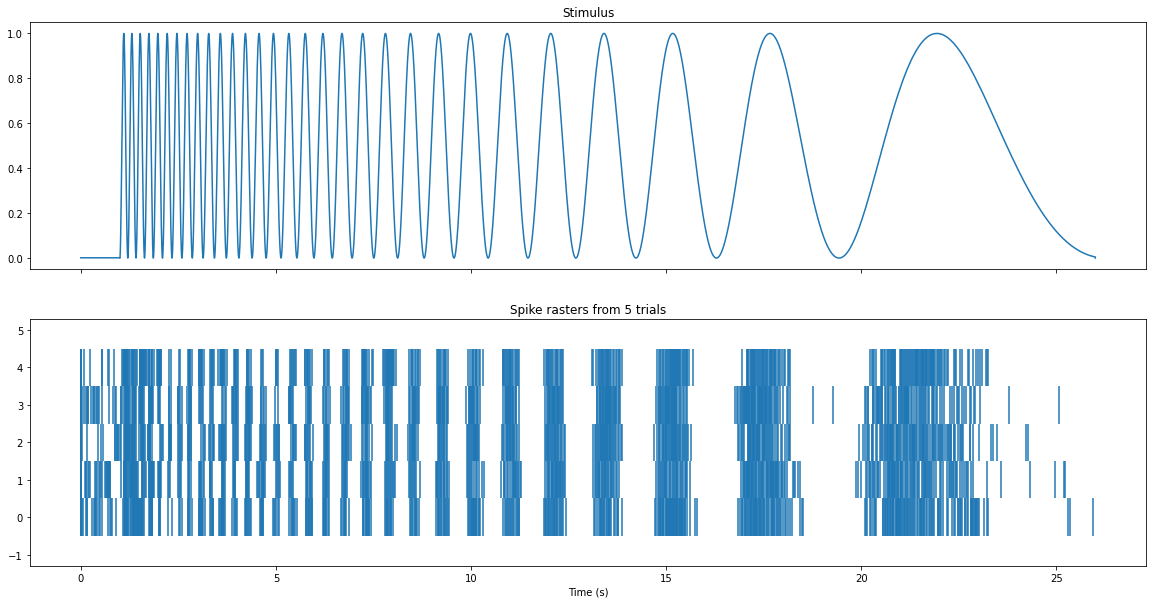

In [6]:
t = np.arange(0, len(stim)) * dt
fig, ax = plt.subplots(2, 1, sharex=True, figsize=[20, 10])
ax[0].plot(t, stim[:, 0])

test = [sps[:, i] * np.arange(len(stim)) * dt for i in range(5)]

ax[1].eventplot(np.array(test));

ax[0].set_title('Stimulus')
ax[1].set_title('Spike rasters from 5 trials')
ax[1].set_xlabel('Time (s)')

# Express our filter using a temporal basis

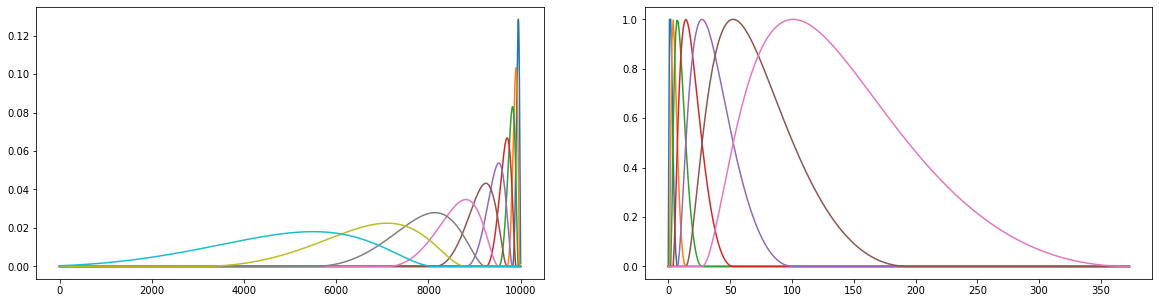

In [7]:
stim_basis, spike_basis = make_bases(10., [0.05, 4.5], 10, 40, dt=0.001)

fig, ax = plt.subplots(1, 2, figsize=[20, 5])
ax[0].plot(stim_basis.B)
ax[1].plot(spike_basis.B)

# Now we will do 3 things:
1. create a design matrix for each trial
2. organize our design matrices into training and testing datasets. 

To make this more clear, lets run the code and visualize a design matrix for one trial


In [8]:
ntrials = sps.shape[1]
inds = np.arange(ntrials)  # trial indices used to make splits

folds_xtrain = []
folds_xtest = []
folds_ytrain = []
folds_ytest = []

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(inds)
for train_index, test_index in loo.split(inds):
  # each fold will consist of a design matrix that will have concatenated trials for that fold
  # e.g. the first fold will train on trials 1, 2, 3 and test on 0
  # the second fold will train on 0, 2, 3 and test on 1
  print("TRAIN:", train_index, "TEST:", test_index)

  # use the inds to take a slice of sps and make a train design matrix
  train_dspec = make_dspec(stim[:, train_index], sps[:, train_index], dt)
  train_dspec.addRegressorContinuous(basis=stim_basis)
  train_dspec.addRegressorSpTrain(basis=spike_basis)

  # use the inds to take a slice of sps and make a test design matrix
  test_dspec = make_dspec(stim[:, test_index], sps[:, test_index], dt)
  test_dspec.addRegressorContinuous(basis=stim_basis)
  test_dspec.addRegressorSpTrain(basis=spike_basis)

  dm, X_train, y_train = train_dspec.compileDesignMatrixFromTrialIndices();
  dm, X_test, y_test = test_dspec.compileDesignMatrixFromTrialIndices();

  folds_xtrain.append(X_train)
  folds_xtest.append(X_test)
  folds_ytrain.append(y_train)
  folds_ytest.append(y_test)
;

  0%|          | 0/4 [00:00<?, ?it/s]

TRAIN: [1 2 3 4] TEST: [0]


  0%|          | 0/4 [00:00<?, ?it/s]

TRAIN: [0 2 3 4] TEST: [1]


  0%|          | 0/4 [00:00<?, ?it/s]

TRAIN: [0 1 3 4] TEST: [2]


  0%|          | 0/4 [00:00<?, ?it/s]

TRAIN: [0 1 2 4] TEST: [3]


  0%|          | 0/4 [00:00<?, ?it/s]

TRAIN: [0 1 2 3] TEST: [4]


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


''

# Visualize a design matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: set_ticks() must have been called.


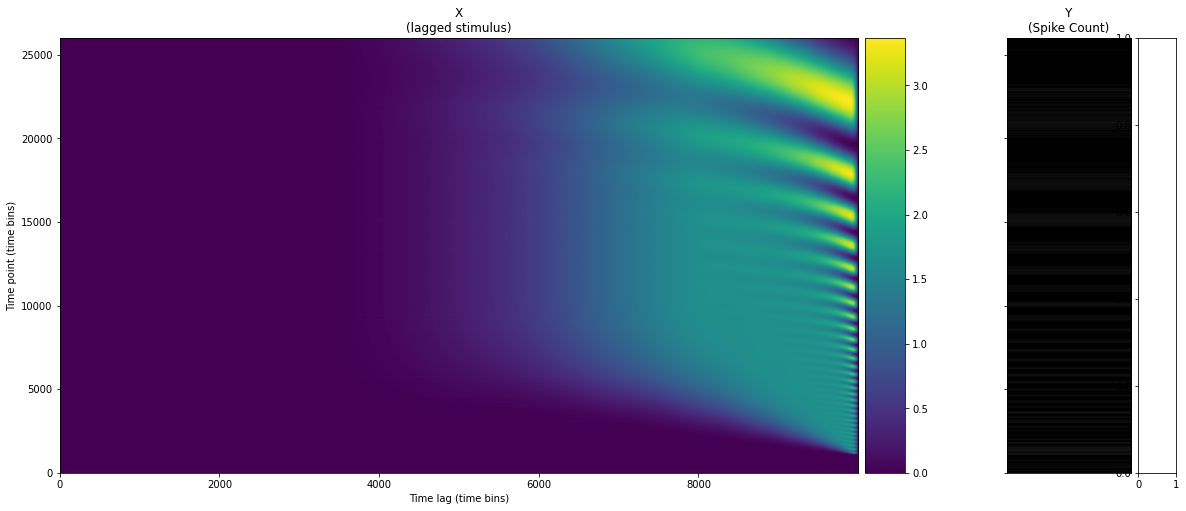

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is our design matrix
f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(20, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )

imx = ax_x.imshow(X_train[:len(stim), 1:stim_basis.nbases+1] @ stim_basis.B.T,
            interpolation='nearest', aspect='auto')
imy = ax_y.imshow(y_train[:len(stim)].reshape(-1, 1), aspect='auto', cmap=plt.cm.gray)
ax_y.invert_yaxis()

ax_y.set(
    title="Y\n(Spike Count)",
    xticks=[]
  )

plt.setp(ax_y.spines.values(), visible=True)


ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    #xticks=[0, 100, 200, 300, 400, 500],
    #xticklabels=['-12', '-10', '-8', '-6', '-4', '-2'],
    ylabel="Time point (time bins)",
  )
plt.setp(ax_x.spines.values(), visible=True)

divy = make_axes_locatable(ax_y)
caxy = divy.append_axes("right", size="30%", pad=0.1)
# cbary = f.colorbar(imy, cax=caxy)
# cbary.set_ticks(np.arange(y_train.max()) + .5)
# cbary.set_ticklabels(np.arange(y_train.max()))

divx = make_axes_locatable(ax_x)
caxx = divx.append_axes("right", size="5%", pad=0.1)
cbarx = f.colorbar(imx, cax=caxx)
cbarx.set_ticklabels(np.sort(np.unique(X_train)))

# Train the model (find regression weights) with Cross-validation
Given a dataset the goal of ridge regression is to learn a linear function of the features in our design matrix. For info on how Ridge regression avoids overfitting, see https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db

Cross-validation is used to find the value of the ridge penalty that minimizes a given metric across different types of splits of the trial data. This model would generalize to each trial equally well as opposed to overfitting on a single trial.

For a more detailed explanation of leave-one-out cross-validation, see https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

Generally, leave-one-out cross-validation

The cross-validation has a single parameter “k” that controls the number of subsets that a dataset is split into. In leave-one-out, k = 5 = the number of trials in our experiment. Once split, each subset is given the opportunity to be used as a test set while all other subsets together are used as a training dataset.

This means that k-fold cross-validation involves fitting and evaluating k models. This, in turn, provides k estimates of a model’s performance on the dataset, which can be reported using summary statistics such as the mean and standard deviation. This score can then be used to compare and ultimately select a model and configuration to use as the “final model” for a dataset.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1GeYu-c1XYIfIl25KklmAV-QAQN_IF9zZ'>
<figcaption>Schematic of the leave-one-out cross-validation.  </figcaption></center>
</figure>


In [31]:
# # Now perform MAP fitting with ridge regression
# neg_log_func = lambda prs, train, test: neg_log_lik(prs, stim_basis.nbases, train, test, 1)

# # regularization
# nlam = 10
# lamvals = np.logspace(-5, 5, num=nlam, base=2)

# Imat = np.eye(stim_basis.nbases + spike_basis.nbases + 1)
# Imat[0, 0] = 0

# # negLTrain = np.zeros((nlam, 1))
# negLTest = np.zeros((nlam, len(folds_xtrain)))

# print('====Doing grid search for ridge parameter====\n')
# prs = np.random.normal(0, 0.1, stim_basis.nbases + spike_basis.nbases + 1)
# res = minimize(neg_log_lik, prs, args=(stim_basis.nbases, folds_xtrain[0], folds_ytrain[0], 1),
#         options={'disp': True})

# wmap = res['x']
# d = dm.get_regressor_from_output(wmap)

# dc = wmap[0]
# k = d['stim'][1]
# kt = d['stim'][0] * dt
# h = d['sptrain'][1]
# ht = d['sptrain'][0] * dt

# wmap_vec = np.tile(wmap, (len(folds_xtrain), 1)).T
# for jj in range(nlam):

#   print('lambda={:.3f}'.format(lamvals[jj]))

#   # parallelize the processing of folds since they are independent
#   for kk in range(len(folds_xtrain)):
#     wmap = wmap_vec[:, kk]

#     Cinv = lamvals[jj] * Imat
#     X_train, X_test = folds_xtrain[kk], folds_xtest[kk]
#     y_train, y_test = folds_ytrain[kk], folds_ytest[kk]
#     wmap_vec[:, kk] = mapfit_GLM(wmap, stim_basis.nbases, X_train, np.array(y_train), Cinv, 1);

#     # test negative log liklihood for lambda val jj and fold kk
#     negLTest[jj, kk] = neg_log_func(wmap, X_test, y_test)

#     print(negLTest[jj, kk])

# # Select best ridge param and fit on all data (meaning on all trials).
# # make another design matrix which has all the data not just train and test
# imin = np.argmin(negLTest.mean(axis=1))


# This is code to parallelize the cross-validation using the joblib library

In [10]:
from joblib import Parallel, delayed

# Now perform MAP fitting with ridge regression
neg_log_func = lambda prs, train, test: neg_log_lik(prs, stim_basis.nbases, train, test, 1)

# regularization
nlam = 10
lamvals = np.logspace(-5, 5, num=nlam, base=2)

Imat = np.eye(stim_basis.nbases + spike_basis.nbases + 1)
Imat[0, 0] = 0

prs = np.random.normal(0, 0.1, stim_basis.nbases + spike_basis.nbases + 1)
res = minimize(neg_log_lik, prs, args=(stim_basis.nbases, folds_xtrain[0], folds_ytrain[0], 1),
        options={'disp': True, 'maxiter': 500})

wmap = res['x']

         Current function value: 7619.139372
         Iterations: 80
         Function evaluations: 1981
         Gradient evaluations: 99


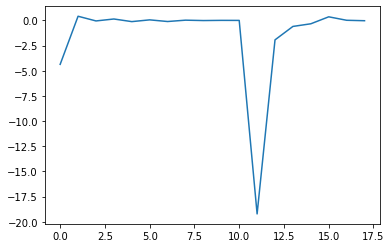

In [11]:
plt.plot(wmap)

In [12]:
def _fit_and_score(train, test, wmap, parameter):
  negLTest = []
  for train, test in zip(train, test):
    Xtrain, ytrain = train
    Xtest, ytest = test

    Cinv = parameter * Imat
    
    wmap_ = mapfit_GLM(wmap, stim_basis.nbases, Xtrain, np.array(ytrain), Cinv, 1);
 
    negLTest.append(neg_log_func(wmap_, Xtest, ytest))

  return np.mean(negLTest)


In [13]:
from tqdm import tqdm
def _run_search(evaluate_candidates):
  """Search all candidates in param_grid"""
  evaluate_candidates(lamvals)


parallel = Parallel(n_jobs=10, verbose=10)

all_out = []


with parallel:

  def evaluate_candidates(candidate_params):
    out = parallel(delayed(_fit_and_score)(train=zip(folds_xtrain, folds_ytrain), 
                                          test=zip(folds_xtest, folds_ytest),
                                          wmap=wmap,
                                          parameter=param)
                  for param in candidate_params) 

    all_out.extend(out)

_run_search(evaluate_candidates)

print(all_out)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  5.2min remaining: 12.2min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:  6.6min remaining:  6.6min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 10.0min remaining:  4.3min


[1934.3168565624605, 1934.3291261242807, 1934.450399115379, 1934.6910982600446, 1935.0998640083046, 1935.8188995569362, 1937.1464767742132, 1939.570087596231, 1943.796260929367, 1950.9521685447671]


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 10.2min finished


best ridge param is 0.03125


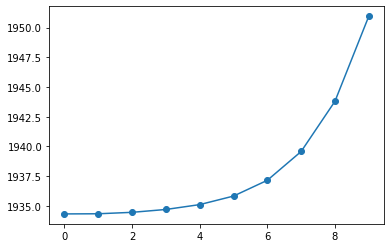

In [14]:
imin = np.argmin(all_out)
print("best ridge param is {}".format(lamvals[imin]))
plt.plot(all_out, 'o-')

# Train the model on the entire dataset now (including all trials)

In [15]:

# fit on entire dataset with this ridge penalty
dspec = make_dspec(stim, sps, dt)
dspec.addRegressorContinuous(basis=stim_basis)
dspec.addRegressorSpTrain(basis=spike_basis)

dm, X, y = dspec.compileDesignMatrixFromTrialIndices()
wmap = mapfit_GLM(wmap, stim_basis.nbases, X, y, lamvals[imin]*Imat, 1)

d = dm.get_regressor_from_output(wmap)

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


         Current function value: 9644.217672
         Iterations: 37
         Function evaluations: 1021
         Gradient evaluations: 51


(0.005, 0.5)

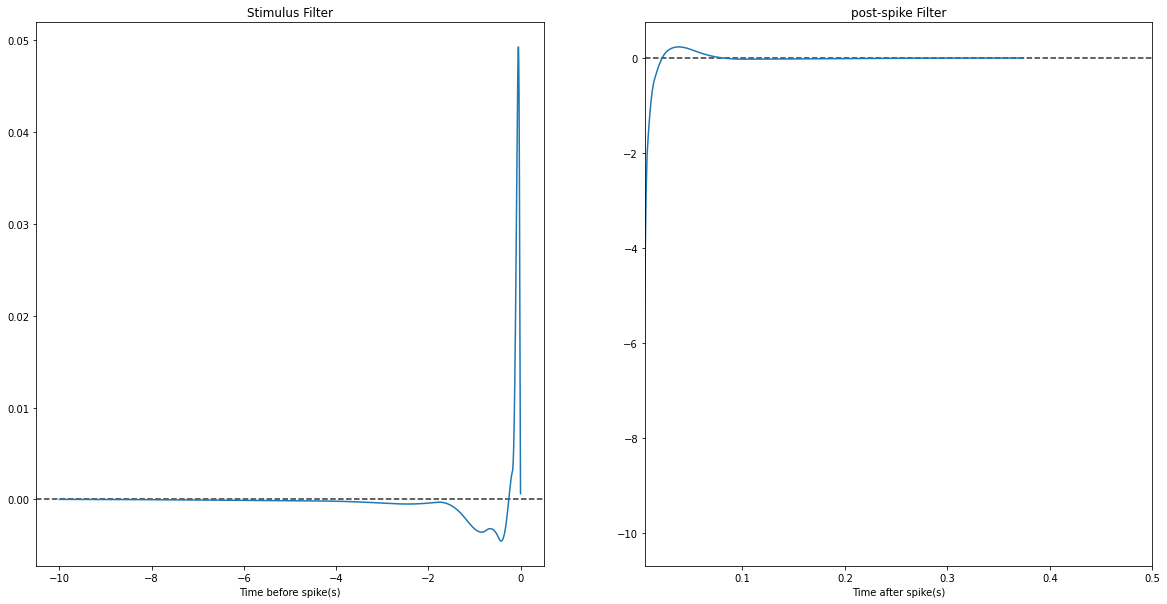

In [17]:

dc = wmap[0]
k = d['stim'][1]
kt = d['stim'][0] * dt
h = d['sptrain'][1]
ht = d['sptrain'][0] * dt

figure, ax = plt.subplots(1, 2, figsize=[20, 10])
ax[0].plot(kt, k)
ax[1].plot(ht, h)
ax[0].axhline(0, color=".2", linestyle="--", zorder=1)
ax[1].axhline(0, color=".2", linestyle="--", zorder=1)
ax[0].set_xlabel('Time before spike(s)')
ax[1].set_xlabel('Time after spike(s)')
ax[0].set_title('Stimulus Filter')
ax[1].set_title('post-spike Filter')
ax[1].set_xlim(0.005, 0.5)
#ax[0].set_xlim(-2, 0)

# Now lets incorporate these filters in a GLM, simulate spiking and compare to our experimental data

# First simulate the GLM 10 times (we'll compute a PSTH over all trials)

In [18]:
# make a prediction on the average response
glm = GLM(dspec.expt.dtSp, k, h, dc)
nsims = 10
glm_sims = np.zeros((sps.shape[0], nsims))
glm_sptimes = np.zeros((sps.shape[0], nsims))
for i in range(nsims): # run 5 GLM simulations
  tsp, sps, itot, istm = glm.simulate(stim[:, 0])
  glm_sptimes[:, i] = sps * np.arange(len(sps)) * dt
  glm_sims[:, i] = sps


# Lets plot the PSTH using the spikes from our GLM simulation with the experimentally recorded spikes

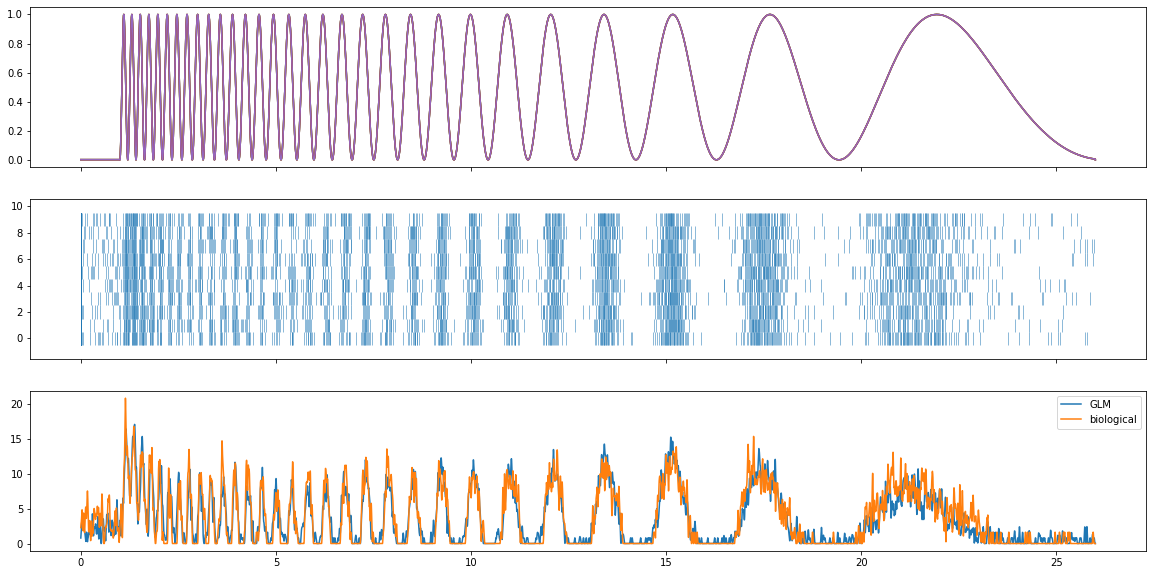

In [19]:
t = np.arange(0, len(stim)) * dt
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[20, 10])
ax[0].plot(t, stim)

# ax[0].eventplot(sptimes.T, lineoffsets=0.7)

ax[1].eventplot(glm_sptimes.T, linewidth=0.5)
smooth_win = np.hanning(50) / np.hanning(50).sum()
psth_model = np.convolve(np.mean(glm_sims, axis=1), smooth_win)
sigrange = np.arange(50 // 2, 50 // 2 + len(sps))
psth_model_ = psth_model[sigrange] * 200
ax[2].plot(t, psth_model_, label='GLM')
#

_, sps_exp, dt = load_spk_times2('datasets/stim.txt', response, dt=0.001)
psth_exp = np.convolve(np.mean(sps_exp, axis=1), smooth_win, mode='full')
sigrange = np.arange(50 // 2, 50 // 2 + len(sps_exp))
psth_exp_ = psth_exp[sigrange] * 200
ax[2].plot(t, psth_exp_, label='biological')

ax[2].legend()

The r2 is 0.7888737522172626
The rmse is 8.050069821362232


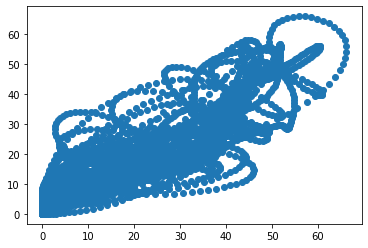

In [186]:
plt.plot(psth_exp_, psth_model_, 'o')
r2 = r2_score(psth_exp_, psth_model_)

mse = mean_squared_error(psth_exp_, psth_model_)

print('The r2 is {}'.format(r2))
print('The rmse is {}'.format(np.sqrt(mse)))

[6.06903045 6.27711839 6.48433451 ... 1.49754432 1.35545341 1.22010652]
